# Classification Experiment: Combining Classifiers
---
This Notebook, includes a series of experiments, on using a node's Social Information for classification.

Libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
import json
import tweepy
import time

from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion

from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

import joblib
import time 

import seaborn as sns

from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

Twitter API Authentication:

In [2]:
twitter_credentials = []
with open('../../../../twitter_credentials.json', 'r') as f:
    twitter_credentials = json.load(f)

auth = tweepy.OAuthHandler(twitter_credentials['consumer_key'], twitter_credentials['consumer_secret'])
auth.set_access_token(twitter_credentials['access_token_key'],twitter_credentials['access_token_secret'])
API = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True, timeout=60*5)

In [3]:
# Function For Text Normalization
def clean_text(data):
    urls = r'http\S+'
    non_unicode_char = r'\W'
    numbers = r'[0-9_]'
    fix_whitespace = r'\s+'
    single_whitespace = ' '
    
    data = (data.replace([urls], single_whitespace, regex=True)
                    .replace([non_unicode_char, numbers], single_whitespace, regex=True)
                    .replace(fix_whitespace, single_whitespace, regex=True))
    data = data.apply(lambda s: s.lower() if type(s) == str else s)
    return data

nlp_el = spacy.load('el_core_news_md')
nlp_en = spacy.load('en_core_web_sm')
STOPWORDS = set(list(spacy.lang.en.STOP_WORDS) + list(spacy.lang.el.STOP_WORDS))

def remove_stopwords(row):
    row = [str(token) for token in nlp_el(row)]
    return [w for w in row if w not in STOPWORDS]

def tokenize_lemmatize(row):
    return [str(token.lemma_) for token in nlp_el(row)]

# Dataset
---

In [4]:
training_set = pd.read_csv('../../../../datasets/Greek Politicians/classification/parliament_members_training_set.csv')
training_set = training_set.replace(np.nan, '')


validation_set = pd.read_csv('../../../../datasets/Greek Politicians/classification/parliament_members_validation_set.csv')
validation_set = validation_set.replace(np.nan, '')

# Classifiers

## Name Description

In [5]:
def get_text_data_nd_(df):
    df = df.copy()
    df['textdata'] = clean_text(df['name'] + ' ' + df['description'])
    df['textdata'] = df['textdata'].apply(lambda row: tokenize_lemmatize(row))
    df['textdata'] = df['textdata'].apply(lambda row: ' '.join(row))
    df['textdata'] = df['textdata'].apply(lambda row: remove_stopwords(row))
    df['textdata'] = df['textdata'].apply(lambda row: ' '.join(row))
    
    return df.textdata


get_text_nd = FunctionTransformer(get_text_data_nd_)

pipeline_nd = Pipeline([
    ('selector_nd', get_text_nd),
    ('tfidf', TfidfVectorizer(max_df=0.5, max_features=2000, min_df=1)),
    ('lr', LogisticRegression(max_iter=1000, C=0.1, penalty = 'l2'))
])

## Statuses

In [6]:
def get_text_data_t_(df):
    df = df.copy()
    df['textdata'] = clean_text(df['recent_100_tweets'])
    df['textdata'] = df['textdata'].apply(lambda row: tokenize_lemmatize(row))
    df['textdata'] = df['textdata'].apply(lambda row: ' '.join(row))
    df['textdata'] = df['textdata'].apply(lambda row: remove_stopwords(row))
    df['textdata'] = df['textdata'].apply(lambda row: ' '.join(row))
    return df.textdata

get_text_data_t = FunctionTransformer(get_text_data_t_)


def get_numeric_data_m_(df):
    data = df['mentions_politician_count'].to_numpy()
    return data.reshape(-1,1)

get_numeric_data_m = FunctionTransformer(get_numeric_data_m_)


pipeline_tme = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features_m', Pipeline([
                ('selector_num_m', get_numeric_data_m)
            ])),
             ('text_features', Pipeline([
                ('selector_text_t', get_text_data_t),
                ('vectorizer', TfidfVectorizer(max_df=0.75, max_features=1000, min_df=10)),
            ]))
         ])),
     ('lr', LogisticRegression(max_iter=1000, C=10, penalty='l2'))
])

## Friends

In [7]:
# Function to select the data
def get_data_fr_(df):
    data = df['friends_politician_count_1000'].to_numpy()
    return data.reshape(-1,1)


get_data_fr = FunctionTransformer(get_data_fr_)

# The pipeline
pipeline_fr = Pipeline([
    ('selector_fr', get_data_fr),
    ('knn', KNeighborsClassifier(n_neighbors=7, weights='uniform'))
])

## Followers

In [8]:
# Function to select the data
def get_data_fo_(df):
    data = df['followers_politician_count_1000'].to_numpy()
    return data.reshape(-1,1)


get_data_fo = FunctionTransformer(get_data_fo_)

# The pipeline
pipeline_fo = Pipeline([
    ('selector_fo', get_data_fo),
    ('knn', KNeighborsClassifier(n_neighbors=12, weights='uniform'))
])

In [9]:
predictions = pd.DataFrame()
predictions['screen_name'] = validation_set['screen_name']
predictions['true_label'] = validation_set['parliament_member']

In [10]:
target_names = ['Not-Parliament-Member', 'Parliament-Member']

# Voting Classifier "Soft"

## Uniform Weights

## Constant Weights

Fitting 5 folds for each of 7 candidates, totalling 35 fits
 Best Params: {'voting__weights': [10, 3, 0.5, 0.5]}.
 Score: 0.9299999999999999
                       precision    recall  f1-score   support

Not-Parliament-Member       0.96      0.98      0.97        50
    Parliament-Member       0.98      0.96      0.97        50

             accuracy                           0.97       100
            macro avg       0.97      0.97      0.97       100
         weighted avg       0.97      0.97      0.97       100



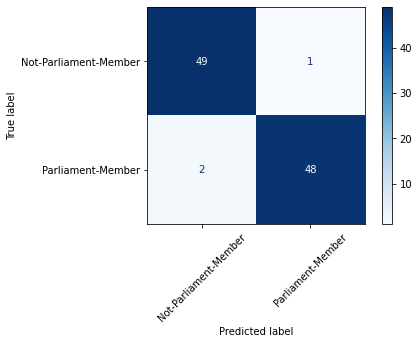

In [14]:
clf = VotingClassifier(estimators=[('nd', pipeline_nd), 
                                   ('tme', pipeline_tme), 
                                   ('fr', pipeline_fr), 
                                   ('fo', pipeline_fo)], 
                       voting='soft'
                      )

pipe = Pipeline([('voting', clf)])


parameters = {'voting__weights':[[10, 10, 5, 5],
                                 [10, 5, 1, 1],
                                 [5, 10, 1, 1],
                                 [5, 5, 2, 0.5],
                                 [1,1,1,1],
                                 [10,3,0.5,0.5],
                                 [3,10,0.5,0.5]]}

grid = GridSearchCV(pipe, parameters, n_jobs = 4, verbose=1)
grid.fit(training_set, training_set.parliament_member)

print(f' Best Params: {grid.best_params_}.\n Score: {grid.best_score_}')


plot_confusion_matrix(grid.best_estimator_, 
                      validation_set, 
                      validation_set.parliament_member, 
                      display_labels=target_names, 
                      xticks_rotation=45, 
                      cmap=plt.cm.Blues)

y_pred=grid.best_estimator_.predict(validation_set)

print(classification_report(y_true = validation_set.parliament_member, 
                            y_pred=y_pred, 
                            target_names=target_names))


predictions['voting_soft_weights'] = y_pred

## Varying Weights

In [15]:
pipeline_nd.fit(training_set, training_set.parliament_member)
nd_proba = pipeline_nd.predict_proba(validation_set).round(4)

In [16]:
pipeline_tme.fit(training_set, training_set.parliament_member)
tme_proba = pipeline_tme.predict_proba(validation_set).round(4)

In [17]:
pipeline_fr.fit(training_set, training_set.parliament_member)
fr_proba = pipeline_fr.predict_proba(validation_set).round(4)

In [18]:
pipeline_fo.fit(training_set, training_set.parliament_member)
fo_proba = pipeline_fo.predict_proba(validation_set).round(4)

In [19]:
a = [10 for i in range(len(validation_set))]
b = [3 for i in range(len(validation_set))]
c = [0.5 for i in range(len(validation_set))]
d = [0.5 for i in range(len(validation_set))]

for i, description in enumerate(validation_set['description']):
    if description == '':
        a[i] = 0.5
    if validation_set.iloc[i]['statuses_count'] == 0:
        b[i] = 0
    if validation_set.iloc[i]['friends_count'] == 0:
        c[i] = 0
    if validation_set.iloc[i]['followers_count'] == 0:
        d[i] = 0
        

In [20]:
proba = [0 for i in range(len(validation_set))]
for i in range(len(validation_set)):
    proba[i] = (a[i]*nd_proba[i] + b[i]*tme_proba[i] + c[i]*fr_proba[i] + d[i]*fo_proba[i]) / (a[i]+b[i]+c[i]+d[i])


    
print(classification_report(y_true = validation_set.parliament_member, 
                            y_pred=np.argmax(proba, axis=1), 
                            target_names=target_names))

                       precision    recall  f1-score   support

Not-Parliament-Member       0.98      0.98      0.98        50
    Parliament-Member       0.98      0.98      0.98        50

             accuracy                           0.98       100
            macro avg       0.98      0.98      0.98       100
         weighted avg       0.98      0.98      0.98       100



[Text(0.5, 0, 'Not-Parliament-Member'), Text(1.5, 0, 'Parliament-Member')]

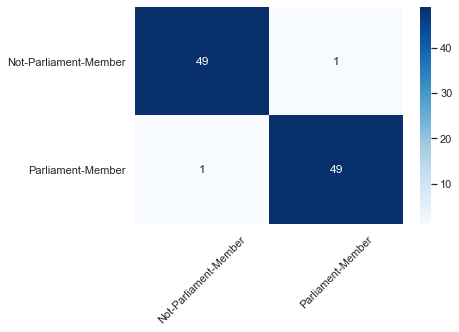

In [21]:
df_cm = pd.DataFrame(confusion_matrix(y_true = validation_set.parliament_member, 
                            y_pred=np.argmax(proba, axis=1)), range(2), range(2))
#plt.figure(figsize=(10,7))
sns.set(font_scale=1) # for label size
mtrx = sns.heatmap(df_cm, annot=True, annot_kws={"size": 12},
           cmap=plt.cm.Blues,
           xticklabels=target_names, 
            yticklabels=target_names) # font size

loc, labels = plt.xticks()
mtrx.set_xticklabels(labels, rotation=45)

In [22]:
predictions[
    (predictions['true_label'] != predictions['voting_soft_weights'])
]

,screen_name,true_label,voting_soft,voting_soft_weights
7,tzakri,1,0,0
18,RoussopoulosTh,1,0,0
55,Georgadas,0,1,1
